In [7]:
%matplotlib notebook

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import exifread
import os
from datetime import datetime
from itertools import islice
from scipy import interpolate
import math
from IPython.display import clear_output
import glob
from pyproj import transform, CRS
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib notebook

In [8]:
# set data variables
path_all_files = '/Volumes/GoogleDrive/Shared drives/LCR N Ellesmere glaciers/Air_photos/July_2019_collection/July28_2019_Thores_Glacier&Lake_&_Ward_Hunt_Ice_Rise/'
ppp_processed_gps_path = path_all_files+'GPS_files/PPP_FINAL/ant_2090.pos'
rinex_path = path_all_files+'GPS_files/July28_2019/ant_2090.19o'
#photo_folder_path = '/Volumes/Kluane Field Data 4TB/Yukon 2019/September 2019/6sept2019_air_photos_donjek_littleKluane_Lowell/air_photos/'
photo_folder_path = '/Volumes/Hubbard/Ward_Hunt/Ward_Hunt_Thores_air_photos_July28_2019/DNG/'

os.chdir(path_all_files)
%mkdir output

x_offset = 0.0001 # in meters (distance in front of the GPS unit, will be negative if camera is behind the unit)
y_offset = 0.0001 # in meters (distance to the right of the GPS unit, will be negative if camera is to left of unit)
z_offset = -130 # in meters (will always be a negative number because your camera is below the antenna on top of the aircraft)

mkdir: output: File exists


In [40]:
#read in PPP corrected data (from NR CAN)
pos_data = pd.read_csv(ppp_processed_gps_path,header=5,delim_whitespace=True)

#get times for all GPS positions
pos_time =[]
for i in range(0,len(pos_data)):
    pos_time.append(datetime.strptime(pos_data['YEAR-MM-DD'][i]+'/'+pos_data['HR:MN:SS.SS'][i],'%Y-%m-%d/%H:%M:%S.%f'))

#Figure out the number of seconds that have occured since Jan 1, 2000 so that you have a number, not a date for later analysis
pos_sec_since = []
jan1_2000 = datetime(2000,1,1)
for i in range(0,len(pos_time)):
    pos_sec_since.append((pos_time[i]-jan1_2000).total_seconds())

#Next we need to convert the GPS position to the position the camera was in when the GPS point was collected.
#Once we do this, we will use the camera position as the GPS position to marry the event and GPS records
#This will use the x, y, and z offsets you described above.
cam_pos_easting = []
cam_pos_northing = []
cam_pos_elev = []
cam_utm_zone = []

#calculate the bearing based on your x and y offsets (you need the negative sign for the y offset)
bearing = math.degrees(np.arctan(-y_offset/x_offset))
#calculate the total distance of the offset from the x and y offsets.
offset_distance = np.sqrt(y_offset**2+x_offset**2)

#calculate the offset in this loop:
for i in range(0,len(pos_data.UTM_EASTING)-1):
    #Euclidean distance between vectors
    dist = math.sqrt((pos_data.UTM_EASTING[i+1] - pos_data.UTM_EASTING[i])**2 + (pos_data.UTM_NORTHING[i+1] - pos_data.UTM_NORTHING[i])**2)
    
    #Get a normalized difference vector so that you can multiply your offset_distance later
    diffVec = (pos_data.UTM_EASTING[i+1] - pos_data.UTM_EASTING[i])/dist, (pos_data.UTM_NORTHING[i+1] - pos_data.UTM_NORTHING[i])/dist
    
    #rotate our vector by bearing to get a vector from orig towards new point
    #also, multiply by distance to get new value
    angle = math.radians(bearing) #convert your bearing from the x y offset to radians for use in the next step 

    #calculate your camera positions based on the offset in the x and y directions
    cam_pos_easting.append(pos_data.UTM_EASTING[i]+(diffVec[0]*math.cos(angle) - diffVec[1]*math.sin(angle))*offset_distance)
    cam_pos_northing.append(pos_data.UTM_NORTHING[i]+(diffVec[0]*math.sin(angle) + diffVec[1]*math.cos(angle))*offset_distance)
    #also grab the z offset from the constant offset in the z direction (note z_offset should be negative above)
    cam_pos_elev.append(pos_data['HGT(m)'][i] + z_offset)
    #tack on the UTM zone for each camera
    cam_utm_zone.append(pos_data.UTMZONE[i])
    
#read in all the events and times associated with events
#CAREFUL WE LOOSE THE 7TH (AND LAST) DIGIT ON THE SECONDS BECAUSE PYTHON CANT HANDLE OUR PRECISION
#open the RINEX file and get the time stamp that occurs from the event marker
rinex_raw = []
with open(rinex_path) as f:
    for line in f:
        if line.startswith("              *** EXTERNAL EVENT #"):
            rinex_raw.append((list(islice(f, 1))[-1]).strip())

#extract the times for the event markers
event_time = []
for i in range(0,len(rinex_raw)):
    date_str = rinex_raw[i]
    event_time.append(datetime.strptime(date_str[0:24],'%y  %m %d %H %M %S.%f'))
del rinex_raw

#calculate the number of seconds since January 1, 2000 so that we have a number (not a date) to work with
event_sec_since = []
for i in range(0,len(event_time)):
    event_sec_since.append((event_time[i]-jan1_2000).total_seconds())
    
event_sec_since = []
for i in range(0,len(event_time)):
    event_sec_since.append((event_time[i]-jan1_2000).total_seconds())

#do a linear interpolation from the camera positions to the event markers for the entire dataset
#you need the [:-1] on the pos_sec_since because you dont have as many records. You need the bearing between positions, so we cant use the last GPS positio (but this is not a problem)
event_easting = np.interp(event_sec_since,pos_sec_since[:-1],cam_pos_easting)
event_northing = np.interp(event_sec_since,pos_sec_since[:-1],cam_pos_northing)
event_elev = np.interp(event_sec_since,pos_sec_since[:-1],cam_pos_elev)
event_utm = np.interp(event_sec_since,pos_sec_since[:-1],cam_utm_zone) #Keep track of the UTM zone for each point, NOTE THIS IS PROBLEMATIC EVENTS THAT OCCUR BETWEEN TWO POINTS IN TWO DIFFERENT UTM ZONES

#Figure out how much time is between each event marker
diff_between_events = []
for i in range(0,len(event_time)-1):
#     diff_between_events.append((event_time[i+1]-event_time[i]).total_seconds)
    time_diff = ((event_time[i+1]-event_time[i]).seconds)+((event_time[i+1]-event_time[i]).microseconds/1000000)
    diff_between_events.append(time_diff)

#Figure out time between an event marker and the closest GPS point
closest_gps_time_to_event = []
diff_between_event_and_closest_gps_time = []
closest_gps_time_before_event = []
closest_gps_time_after_event = []
diff_between_event_and_closest_gps_time_before_event = []
diff_between_event_and_closest_gps_time_after_event = []
diff_2nd_between_event_and_closest_gps_time = []

#Pick out the closests GPS events and make sure that the second closest GPS event is less than 0.1 s (or whatever your sampling interval is) away from the camera position
for i in range(0,len(event_sec_since)):#-1 because length is longer than index
    if np.abs(np.asarray(event_sec_since[i])-np.asarray(pos_sec_since)).argmin()<=len(pos_sec_since):
        closest_gps_time_before_event.append(pos_sec_since[np.abs(np.asarray(event_sec_since[i])-np.asarray(pos_sec_since)).argmin()-1])#find the closests position to camera, go one behind in index
        diff_between_event_and_closest_gps_time_before_event.append(np.abs(event_sec_since[i]-closest_gps_time_before_event[i]))#subtract to find the time difference between when the event was taken and closest GPS points

        closest_gps_time_after_event.append(pos_sec_since[np.abs(np.asarray(event_sec_since[i])-np.asarray(pos_sec_since)).argmin()+1])#find the closests position to camera, go one ahead in index
        diff_between_event_and_closest_gps_time_after_event.append(np.abs(event_sec_since[i]-closest_gps_time_after_event[i]))#subtract to find the time difference between when the event was taken and closest GPS points

        diff_2nd_between_event_and_closest_gps_time.append(min([diff_between_event_and_closest_gps_time_before_event[i],diff_between_event_and_closest_gps_time_after_event[i]]))
    else:
        diff_2nd_between_event_and_closest_gps_time.append(5)#doesnt matter what you put here, it just need to be bigger than the value you use below so these points will be thrown out
        
#Figure out how many event markers were collected more than 0.1s away from a GPS point
events_far_from_gps = np.asarray(np.abs(diff_2nd_between_event_and_closest_gps_time)>.1)#This number should be half the sample interval of your GPS reciever because
#you need to weed out events that are not between two GPS points that are properly sapced (i.e. 0.1 s for 10 Hz GPS)

#IMPORT PHOTO INFORMATION
#make sure you are in the directory for the photos
os.chdir(photo_folder_path)

#Import all the photo numbers and times
photo_numbers = []
photo_time = []
time_exif = []
photo_name = sorted(glob.glob('DSC*'))

for i in range(0,len(glob.glob('DSC*'))):
    photo_path = photo_folder_path+str(photo_name[i])
    # Open image file for reading (binary mode)
    f = open(photo_path, 'rb')
    # Return Exif tags
    tags = (exifread.process_file(f))
    time_exif = tags['EXIF DateTimeOriginal']
    photo_time.append(datetime.strptime(str(time_exif),'%Y:%m:%d %H:%M:%S'))
    photo_numbers.append((str(photo_name[i])[4:8]))
    clear_output() #This prevents a bunch of crap from populating your screen, it might make your screen spaz, but its better than a bunch of garbage on your screen
    
if len(photo_time) == 0:
    print('You dont have the correct photo directory selected, try again')
    print('Your current directory is:',os.cwd())
    
#Figure out how much time is between each photo
diff_between_photos = []
for i in range(0,len(photo_time)-1):
    time_diff = ((photo_time[i+1]-photo_time[i]).seconds)
    diff_between_photos.append(time_diff)

#Put the photos in order if you had photo 9999 and 1 (aka you wrapped around and started a new directory of photos)
if photo_numbers[-1]=='9999' and photo_numbers[0]=='0001':#you only need this if you have wrapped around and had photos 9999 and 0001
    diff_between_photos.append(np.nan)
    photo_time, diff_between_photos, photo_numbers = zip(*sorted(zip(photo_time, diff_between_photos, photo_numbers)))
    
print('You have',np.count_nonzero(events_far_from_gps),'photo(s) greater than 0.05s from a GPS point (these photos will not have a position in the output file)')
print()    
print('The biggest gap in photos is',np.max(diff_between_photos),'seconds')
print("There are ",np.count_nonzero(event_time)," event markers in this record")
print('There are ',len(photo_numbers), 'photos in this record')


You have 221 photo(s) greater than 0.05s from a GPS point (these photos will not have a position in the output file)

The biggest gap in photos is nan seconds
There are  2444  event markers in this record
There are  2444 photos in this record


In [41]:
print(photo_numbers)

('9518', '9519', '9520', '9521', '9522', '9523', '9524', '9525', '9526', '9527', '9528', '9529', '9530', '9531', '9532', '9533', '9534', '9535', '9536', '9537', '9538', '9539', '9540', '9541', '9542', '9543', '9544', '9545', '9546', '9547', '9548', '9549', '9550', '9551', '9552', '9553', '9554', '9555', '9556', '9557', '9558', '9559', '9560', '9561', '9562', '9563', '9564', '9565', '9566', '9567', '9568', '9569', '9570', '9571', '9572', '9573', '9574', '9575', '9576', '9577', '9578', '9579', '9580', '9581', '9582', '9583', '9584', '9585', '9586', '9587', '9588', '9589', '9590', '9591', '9592', '9593', '9594', '9595', '9596', '9597', '9598', '9599', '9600', '9601', '9602', '9603', '9604', '9605', '9606', '9607', '9608', '9609', '9610', '9611', '9612', '9613', '9614', '9615', '9616', '9617', '9618', '9619', '9620', '9621', '9622', '9623', '9624', '9625', '9626', '9627', '9628', '9629', '9630', '9631', '9632', '9633', '9634', '9635', '9636', '9637', '9638', '9639', '9640', '9641', '9642',

<IPython.core.display.Javascript object>


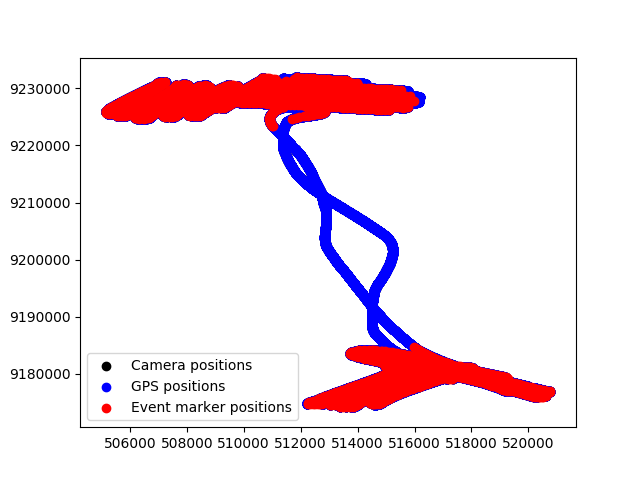

In [12]:
#Plot the positions so that it all makes sense to you on the map, 
#double check that camera is in correct place relative to flight path (optional)

fig, ax = plt.subplots()
scat_cam = ax.scatter(cam_pos_easting,cam_pos_northing,color='k',label='Camera positions')
scat_gps = ax.scatter(pos_data.UTM_EASTING,pos_data.UTM_NORTHING,color='b',label='GPS positions')
scat_event = ax.scatter(event_easting,event_northing,color='r',label='Event marker positions')

plt.legend()




In [27]:
#Special filter for Thores Glacier becauase the event record is perfect
#Set events to final
event_northing_final = event_northing[:]
event_easting_final = event_easting[:]
event_elev_final = event_elev[:]
event_utm_zone_final = event_utm[:]
events_far_from_gps_final = events_far_from_gps[:]

In [77]:
print('There are',len(event_northing),'event markers in this record')
print('There are ',len(photo_numbers), 'photos in this record')
print()
print(diff_between_photos[:30])
print(diff_between_events[:30])
print()
print(diff_between_photos[-50:])
print(diff_between_events[-30:])
print()
print(max(diff_between_photos))
print(max(diff_between_events))
print()
print(min(diff_between_photos))
print(min(diff_between_events))
print()
print(sum(diff_between_photos))
print(sum(diff_between_events))

# diff_between_events.sort()
# diff_between_photos.sort()
# print(diff_between_photos_sorted)

There are 1420 event markers in this record
There are  1420 photos in this record

[4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 37, 4, 3, 3, 3]
[3.956917, 3.027979, 3.024033, 3.02496, 3.023995, 3.02497, 3.027018, 3.024943, 3.023973, 3.024983, 3.023976, 3.027989, 3.024095, 3.024882, 3.024981, 3.023995, 3.027977, 3.024017, 3.025032, 3.023938, 3.024958, 3.023976, 3.027997, 3.025064, 3.023936, 37.036806, 3.959909, 3.024008, 3.024942, 3.027035]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4]
[3.030009, 3.025981, 3.027132, 3.025867, 3.026975, 3.030044, 3.025969, 3.027065, 3.025948, 3.026929, 3.028989, 3.027045, 3.02594, 3.027055, 3.026025, 3.029895, 3.026069, 3.025908, 3.027009, 3.026032, 3.029941, 3.026, 3.026014, 3.026986, 3.025964, 3.027023, 3.028964, 3.026995, 3.026027, 3.027043]

37
37.036806

3
2.77002

4332
4331.296647999995


In [65]:
photo_numbers[-1]-photo_numbers[0]

1431

In [ ]:
#CLEAN PHOTOS
#Clean up the photo record by deleting all the photos before the intervelomter starts
for i in range(0,len(diff_between_photos)):
    if diff_between_photos[i] == diff_between_photos[i+1] and diff_between_photos[i+2] == diff_between_photos[i+1]:
        first_good_photo = i-1    
        break
del diff_between_photos[:first_good_photo]
del photo_numbers[:first_good_photo]
print('We deleted',first_good_photo+1,'photos')
print('Your first 3 photos are', diff_between_photos[0:3], 'seconds apart')
print('Your first photo number is now:',photo_numbers[0])
print('You have',len(photo_numbers),'photos to work with')

print('You have',len(event_northing),'events to work with')

In [12]:
#CLEAN EVENTS
#Clean up the event record by cleaning events before the intervelometer started (aka before you get the 4 then 3 sec first and second shot)
for i in range(0,len(diff_between_events)):
    if diff_between_events[i]>0.90 and diff_between_events[i]-diff_between_events[i+1]>.7 and (diff_between_events[i]-diff_between_events[i+1])<1.3 and abs(diff_between_events[i+1]-diff_between_events[i+2])<0.1:
        first_good_event = i #this is the position of the first good event in the record 
        break
del diff_between_events[:first_good_event]#this deletes the early events that were tests or dont make sense
event_northing_final = event_northing[first_good_event:]
event_easting_final = event_easting[first_good_event:]
event_elev_final = event_elev[first_good_event:]
event_utm_zone_final = event_utm[first_good_event:]
events_far_from_gps_final = events_far_from_gps[first_good_event:]

#Find out how many photos and event are move than 5 seconds apart (These must be breaks in your data)
indices = [i for i, x in enumerate(diff_between_photos) if x > 5]
photo_break_num = indices
photo_break_num.insert(0,0)
photo_break_num.append(len(diff_between_photos)-1)
print('Photos greater than 5s apart + the last photo number and first photo', photo_break_num)

indices = [i for i, x in enumerate(diff_between_events) if x > 5]
event_break_num = indices
event_break_num.insert(0,0)
event_break_num.append(len(diff_between_events)-1)
print('Events greater than 5s apart + last event marker and first event marker', event_break_num)


Photos greater than 5s apart + the last photo number and first photo [0, 305, 411, 516, 1011, 2331, 2425]
Events greater than 5s apart + last event marker and first event marker [0, 305, 411, 516, 1259, 1321, 1324, 2350, 2643, 2738, 2738]


In [13]:
#CONT CLEAN EVENTS ----BE CAREFUL THIS CAN MESS UP YOUR DATA, YOU MAY NEED TO RUN IT SEVERAL TIMES while editing the script between iterations
#Fix the event marker record during the photo process (This happens when you have a false event while you are taking photos or after you finish taking photos)
n=1 #start a counter to break loop at the end

for i in range(1,len(photo_break_num)):
    print()
    print()
    print('starting for loop (again)')
    print('now looking at photo numbers',photo_break_num[i-1],'to',photo_break_num[i])
    
    while True: #go into this loop until you find a good answer in one of the if statements below
        if photo_break_num[i]==event_break_num[i]:
            print('These numbers are good')
            break
            
        print('Number of events', len(event_elev_final))
        print('Number of photos',len(photo_numbers))
        
        #Find out how many photos and event are move than 5 seconds apart (These must be breaks in your data)
        #     PHOTOS
        indices = [i for i, x in enumerate(diff_between_photos) if x > 5]
        photo_break_num = indices
        photo_break_num.insert(0,0)
        photo_break_num.append(len(diff_between_photos)-1)
        print('Photos greater than 5s apart + the last photo number', photo_break_num)
        #     EVENTS
        indices = [i for i, x in enumerate(diff_between_events) if x > 5]
        event_break_num = indices
        event_break_num.insert(0,0)
        event_break_num.append(len(diff_between_events)-1)
        print('Events greater than 5s apart + last event marker', event_break_num)
        
        #add the smallest event to the nearest smallest event (this is assuming the event marker was false/doubled)
        print('Smallest time between two events is:',min(diff_between_events[event_break_num[i-1]:event_break_num[i]]),'seconds')
        print('This event will be merged with the smallest neighbor')
        #find where the least amount of time between two breaks in photography is
        min_event_diff_index = diff_between_events.index(min(diff_between_events[event_break_num[i-1]:event_break_num[i]]))
        print('position to be deleted',min_event_diff_index)
        #Find the smallest event on either side of that
        next_min_event_diff_index = diff_between_events.index(min(diff_between_events[min_event_diff_index-1],diff_between_events[min_event_diff_index+1]))
        print('Right now, your event record looks like this', diff_between_events[min_event_diff_index-1:min_event_diff_index+2])

        #This is finding the smallest time between two events and adding the smallest neighbor too it, because we assume we got a flase event in the middle of the record
        if diff_between_events[min_event_diff_index]+diff_between_events[next_min_event_diff_index] < np.median(diff_between_events)*1.33:#can change 1.33 if you need a larger or more narrow window to throw out events
            #replace the smallest value with the sum of the two above numbers
            diff_between_events[min_event_diff_index]=diff_between_events[min_event_diff_index]+diff_between_events[next_min_event_diff_index]#add the two smallest values in this set together
            #delete the number you just added above
            diff_between_events.pop(next_min_event_diff_index)#delete the value you just added to the min value because you have now combined the events
            #Delete these locations in the event position record because they are flase events
            event_northing_final = np.delete(event_northing_final,next_min_event_diff_index,0)
            event_easting_final = np.delete(event_easting_final,next_min_event_diff_index,0)
            event_elev_final = np.delete(event_elev_final,next_min_event_diff_index,0)
            event_utm_zone_final = np.delete(event_utm_zone_final,next_min_event_diff_index,0)#delete the corresponding data point UTM zone record
            events_far_from_gps_final = np.delete(events_far_from_gps_final,next_min_event_diff_index,0) #keep track of the event(s) that is/are far from a GPS points
            
            print('After combining events, your new record is now this:',diff_between_events[min_event_diff_index-1:min_event_diff_index+2])
            print('You now have',len(event_elev_final),'events')
            print('You now have',len(photo_numbers),'photos')
            print()
        
        #This gets you out of loop if your event is clean now
        if photo_break_num[i]==event_break_num[i]:
            print('These numbers are good, nothing needs to be changed')
            break
        
        #This helps you delete events at the end that were collected as you were flying home
    #                                                                                                 this last part makes it so that it will not run if you have some number of events in middle that dont have photos (ie your camera ran out of memory and took pictures but didnt log them)
        if photo_break_num[i]<event_break_num[i] and event_break_num[-1]-photo_break_num[i]<5 and np.sum(event_break_num)-np.sum(photo_break_num)==event_break_num[-1]-photo_break_num[-1]:#if you are in the last 5 events (change this if you have problems), we assume these are false events because you had a flase trigger flying home  
            del diff_between_events[event_break_num[i]-1:]#delete the values at the end because they are false events after you finish recording
            #delete these same locations in the event record
            event_northing_final = event_northing_final[:event_break_num[i]]
            event_easting_final = event_easting_final[:event_break_num[i]]
            event_elev_final = event_elev_final[:event_break_num[i]]
            event_utm_zone_final = event_utm_zone_final[:event_break_num[i]]
            events_far_from_gps_final = events_far_from_gps_final[:event_break_num[i]]
            
            #This is just here to help see how things ended up and that it all looks good.
            indices = [i for i, x in enumerate(diff_between_photos) if x > 5]
            photo_break_num = indices
            photo_break_num.insert(0,0)
            photo_break_num.append(len(diff_between_photos)-1)
            print('Photos greater than 5s apart + the last photo number', photo_break_num)
            #     EVENTS
            indices = [i for i, x in enumerate(diff_between_events) if x > 5]
            event_break_num = indices
            event_break_num.insert(0,0)
            event_break_num.append(len(diff_between_events)-1)
            print('Events greater than 5s apart + last event marker', event_break_num)
            
            break
            
        n=n+1 #This will just break out if you have looped through 30 times
        if n>30:
            print('You probably took some events while the camera was not taking pictures (i.e. full memory card/switch out)')
            print('look at the next section to fix this')
            break
            
            
print('northing length', len(event_northing_final))
print('easting length', len(event_easting_final))
print('elev length', len(event_elev_final))
print('events far from GPS length', len(events_far_from_gps_final))
print('photo length',len(photo_numbers))



starting for loop (again)
now looking at photo numbers 0 to 305
These numbers are good


starting for loop (again)
now looking at photo numbers 305 to 411
These numbers are good


starting for loop (again)
now looking at photo numbers 411 to 516
These numbers are good


starting for loop (again)
now looking at photo numbers 516 to 1011
Number of events 2740
Number of photos 2427
Photos greater than 5s apart + the last photo number [0, 305, 411, 516, 1011, 2331, 2425]
Events greater than 5s apart + last event marker [0, 305, 411, 516, 1259, 1321, 1324, 2350, 2643, 2738, 2738]
Smallest time between two events is: 2.774925 seconds
This event will be merged with the smallest neighbor
position to be deleted 549
Right now, your event record looks like this [3.288009, 2.774925, 3.031971]
Number of events 2740
Number of photos 2427
Photos greater than 5s apart + the last photo number [0, 305, 411, 516, 1011, 2331, 2425]
Events greater than 5s apart + last event marker [0, 305, 411, 516, 1259

In [7]:
#CONTINUE CLEAN EVENTS - ONLY FOR MISFIRES IN MIDDLE OF RECORD (aka camera triggered but did not record photo maybe because of memory card storage problems)
#MOST SURVEYS DONT NEED TO USE THIS SECTION

#Delete events that are extra in the middle of the record, but are regular (i.e. your camera didnt record photos but you still got events)
#You likely need to run this if you ran out of memory space and didnt realize it instaneously
#IMPORTANT: You need to run the above code to filter out events and photos first, only come to this if you meet the conditions above
counter=0#start a counter to only go through loop below once
if abs(np.sum(diff_between_events)-np.sum(diff_between_photos))<2 and event_break_num[-1]>photo_break_num[-1]:
    for i in range(0,len(event_break_num)):
        if event_break_num[i]>photo_break_num[i] and counter <1:#counter is there so you can't do it twice
            #Get the range of events you want to delete in the location record:
            x = range(photo_break_num[i],event_break_num[i],1)
            event_index_to_delete = []
            for n in x:
                event_index_to_delete.append(n)
                event_index_to_delete=(event_index_to_delete)
            print('Events',event_index_to_delete,'were removed')
            
            #Cycle through and delete the same spot for as many extra events as you have
            # (your array will shrink by one each time too)
            #You will delete the same number of values as you have extra events
            for i in range(0,len(event_index_to_delete)):
                del diff_between_events[event_index_to_delete[i]]
                event_northing_final = np.delete(event_northing_final,event_index_to_delete[i],0)
                event_easting_final = np.delete(event_easting_final,event_index_to_delete[i],0)
                event_elev_final = np.delete(event_elev_final,event_index_to_delete[i],0)
                event_utm_zone_final = np.delete(event_utm_zone_final,event_index_to_delete[i],0)
                events_far_from_gps_final = np.delete(events_far_from_gps_final,event_index_to_delete[i],0)
            counter=counter+1
            
else:
    print('You should not be using this section or your record is off, look at the record more closely')

    
#Find out how many photos and event are move than 5 seconds apart (These must be breaks in your data)
#     PHOTOS
indices = [i for i, x in enumerate(diff_between_photos) if x > 5]
photo_break_num = indices
photo_break_num.insert(0,0)
photo_break_num.append(len(diff_between_photos)-1)
print('Photos greater than 5s apart + the last photo number', photo_break_num)
#     EVENTS
indices = [i for i, x in enumerate(diff_between_events) if x > 5]
event_break_num = indices
event_break_num.insert(0,0)
event_break_num.append(len(diff_between_events)-1)
print('Events greater than 5s apart + last event marker', event_break_num)
print()
print('northing length', len(event_northing_final))
print('easting length', len(event_easting_final))
print('elev length', len(event_elev_final))
print('events far from GPS length', len(events_far_from_gps_final))
print('photo',len(photo_numbers))

Events [3701, 3702, 3703] were removed
Photos greater than 5s apart + the last photo number [0, 1054, 1226, 3701, 4177]
Events greater than 5s apart + last event marker [0, 1054, 1226, 3702, 4177]

northing length 4179
easting length 4179
elev length 4179
events far from GPS length 4179
photo 4179


In [18]:
print(len(photo_numbers))
print(photo_numbers[0])
print(photo_numbers[-1])
print(8017-5278)

2427
5278
8017
2739


In [31]:
#Identify areas that you might be missing photos (only need this if you have way more events than photos and think you might be missing something)
photo_numbers_difference = []
for i in range(0,len(photo_numbers)):
    photo_numbers_difference.append(photo_numbers[i]-photo_numbers[i-1])
    
index_value = (photo_numbers_difference.index(max(photo_numbers_difference)))
photo_numbers[index_value-2:index_value+2]

[6288, 6289, 6603, 6604]

In [8]:
#Look at a specific part of the photo record where x is the index number you want to look around
x = 3704
print(diff_between_events[x-5:x+5])
print(diff_between_photos[x-5:x+5])

print(np.sum(diff_between_events))
print(np.sum(diff_between_photos))

[3.03201, 3.030065, 3.02899, 28.695971, 3.029974, 3.029052, 3.029004, 3.032984, 3.029029, 3.028906]
[3, 3, 29, 4, 3, 3, 3, 3, 3, 3]
13108.653373000001
13119


In [91]:
%pwd

'/Volumes/Hubbard/Ward_Hunt/Ward_Hunt_Thores_photos_July15_2019/DNG'

In [42]:
#Make a panadas data frame for photo, x, y, and z
photo_id = []

if len(event_elev_final)==len(photo_numbers):
    for i in range(0,len(photo_numbers)):
        photo_id.append('DSC_'+str(photo_numbers[i])+'.dng')
    export_data = {'photo_id':photo_id, 'x': event_easting_final,'y': event_northing_final,'z': event_elev_final,'UTM_zone':event_utm_zone_final}   
    export_df = pd.DataFrame(data=export_data)
    export_df = export_df[~events_far_from_gps_final]
else:
    print('Cannot create dataframe because you dont have the same number of photos and events')
    
#Print out information about the UTM zone the data is in
if min(export_df.UTM_zone)!=max(export_df.UTM_zone):
    print('You are working in 2 different UTM zones, you need to convert the coordinates to Lat/Lon')
    print('Your UTM zones include', min(export_df.UTM_zone), 'and', max(export_df.UTM_zone))
if min(export_df.UTM_zone)==max(export_df.UTM_zone):
    print('You are working in UTM zone',max(export_df.UTM_zone))
    print('You should know what hemisphere you are in')
    print('you can just run the next section to export in UTM NAD83')

You are working in UTM zone 18.0
You should know what hemisphere you are in
you can just run the next section to export in UTM NAD83


<IPython.core.display.Javascript object>


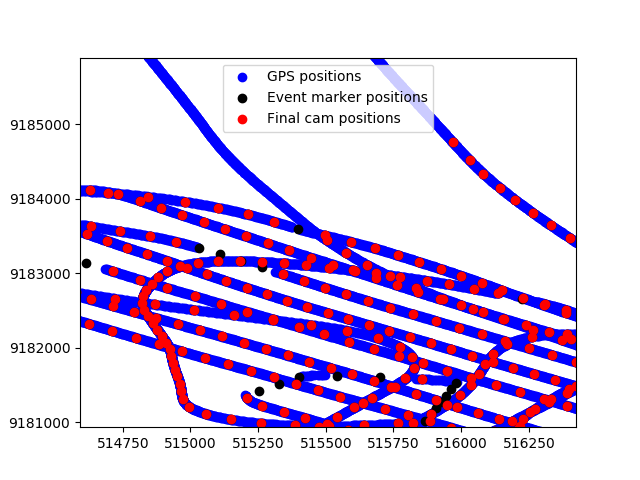

<IPython.core.display.Javascript object>


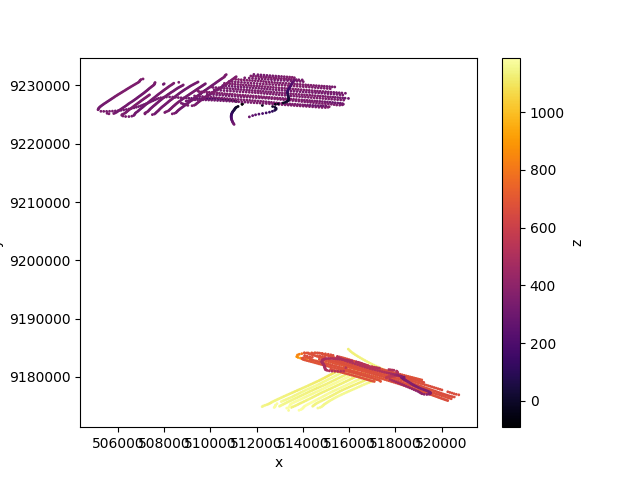

In [43]:
#plot the camera positions ready for export as a last check (OPTIONAL)
fig, ax = plt.subplots()
# scat_cam = ax.scatter(cam_pos_easting,cam_pos_northing,color='k',label='Camera positions')
scat_gps = ax.scatter(pos_data.UTM_EASTING,pos_data.UTM_NORTHING,color='b',label='GPS positions')
scat_event = ax.scatter(event_easting,event_northing,color='k',label='Event marker positions')
scat_final = ax.scatter(export_df.x,export_df.y,color='r',label='Final cam positions')
plt.legend()



export_df.plot(x='x', y='y', kind='scatter', c='z', s=1, cmap='inferno')




In [ ]:
#Check your EPSG code to make sure you are using the one you think you are using (OPTIONAL)
crs = CRS.from_epsg(4269)
crs

In [44]:
#EXPORT DATA AS UTM (this will work well, as long as you dont cross UTM zones)
#This does not change the data at all, just exports it
output_path = path_all_files+'output/processed_data_export_UTM.csv'

#export to csv
export_df.to_csv(path_or_buf=output_path,index=False)
print('REMINDER, SOME PHOTOS MAY NOT HAVE A GPS POSITION (likely because they are not near a pt we collected)')
print('You need to use photos',photo_numbers[0],'to',photo_numbers[-1])
print()

print('Check these photos for your breaks:')
for i in range(0,len(photo_break_num)):
    print(photo_numbers[photo_break_num[i]])
print()
    

REMINDER, SOME PHOTOS MAY NOT HAVE A GPS POSITION (likely because they are not near a pt we collected)
You need to use photos 9518 to 1962

Check these photos for your breaks:


NameError: name 'photo_break_num' is not defined

In [13]:
print(len(lat_final))
print(len(lon_final))
print(len(elev_final))

0
0
0


In [12]:
#EXPORT DATA IN LAT LON (This will work if you were in 2 UTM zones)
#Replace EPSG codes with the UTM zone you were working in*******************
output_path = path_all_files+'output/processed_data_export_lat_lon.csv'

lat_final=[]
lon_final=[]
elev_final=[]
photo_id = []

#WARNING THIS CODE HAS NOT BEEN FULLY TESTED************************************

utm_sort,event_easting_sort, event_northing_sort, event_elev_sort = zip(*sorted(zip(event_utm_zone_final,event_easting_final, event_northing_final,event_elev_final)))

for i in range(1,len(export_df)):
    if utm_sort[i-1]!=utm_sort[i]:
        lon_temp,lat_temp,elev_temp = transform(26907,4269,event_easting_sort[:i],event_northing_sort[:i],event_elev_sort[:i])
        lat_final.extend(lat_temp)#              ^EPSG codes (from,to)
        lon_final.extend(lon_temp)
        elev_final.extend(elev_temp)
        #NEXT UTM zone                           EPSG CODES(from,to)
        lon_temp,lat_temp,elev_temp = transform(26908,4269,event_easting_sort[i:],event_northing_sort[i:],event_elev_sort[i:])
        lat_final.extend(lat_temp)
        lon_final.extend(lon_temp)
        elev_final.extend(elev_temp)
        break
    else:
        print('you are in one UTM zone, you dont need this! Ignore the error message below')
        print('go back to the code above to export data in UTM')

#build a pandas data frame as lat long
if len(event_elev_final)==len(photo_numbers):
    for i in range(0,len(photo_numbers)):
        photo_id.append('DSC_'+str(photo_numbers[i])+'.dng')
    export_data = {'photo_id':photo_id,'x': lat_final, 'y': lon_final,'z': elev_final}   
    export_df = pd.DataFrame(data=export_data)
    export_df = export_df[~events_far_from_gps_final]
else:
    print('Cannot export record because you dont have the same number of photos and events')

#export to csv
export_df.to_csv(path_or_buf=output_path,index=False)
print('REMINDER, SOME PHOTOS MAY NOT HAVE A GPS POSITION (likely because they are not near a pt we collected)')
print('You need to use photos',photo_numbers[0],'to',photo_numbers[-1])
print()


ValueError: arrays must all be same length

In [ ]:
#make a quick plot of your track to see where you went (optional)
export_df.plot(x='x', y='y', kind='scatter', c='z', s=1, cmap='inferno')

<IPython.core.display.Javascript object>


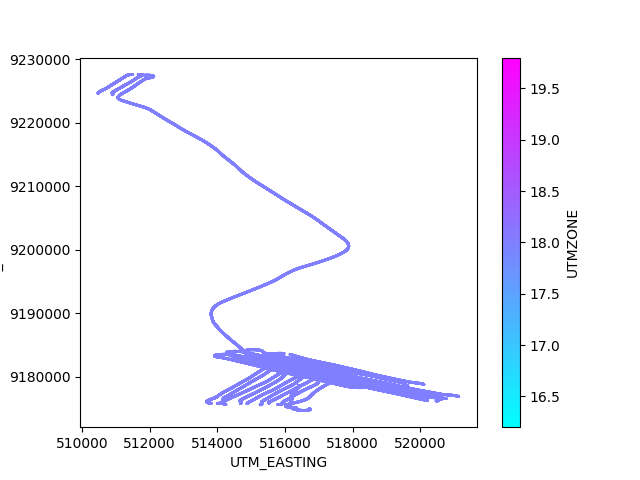

In [78]:
#make a quick plot of your track to see which UTM zones you are in and where you are
pos_data.plot(x='UTM_EASTING', y='UTM_NORTHING', kind='scatter', c='UTMZONE', s=1, cmap='cool')

<IPython.core.display.Javascript object>


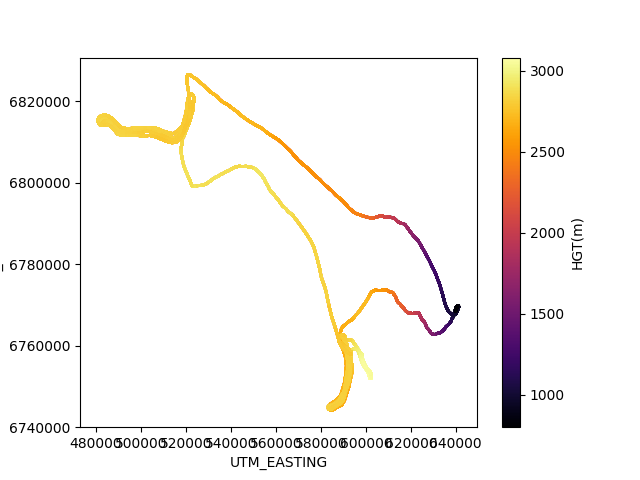

In [14]:
#make a quick plot of your track to see where you went (optional)
pos_data.plot(x='UTM_EASTING', y='UTM_NORTHING', kind='scatter', c='HGT(m)', s=1, cmap='inferno')

NameError: name 'event_easting_final' is not defined

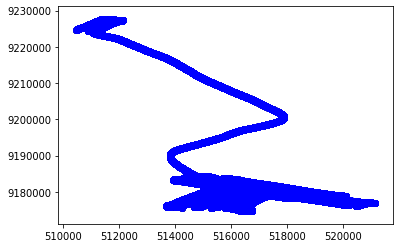

In [8]:
#Plot the positions so that it all makes sense to you on the map, 
#double check that camera is in correct place relative to flight path (optional)

fig, ax = plt.subplots()
scat_cam = ax.scatter(cam_pos_easting,cam_pos_northing,color='k',label='Camera positions')
scat_gps = ax.scatter(pos_data.UTM_EASTING,pos_data.UTM_NORTHING,color='b',label='GPS positions')
scat_event = ax.scatter(event_easting_final,event_northing_final,color='r',label='Event marker positions')

plt.legend()

In [10]:
%matplotlib notebook

In [7]:
#USEFUL COMMANDS (potentially) for trouble shooting event and photo records (not neccessary)

# print('First position time:',min(pos_time))
# print('First event time:',min(event_time))
# print()
# print('Last position time:',max(pos_time))
# print('Last event time:',max(event_time))
# print()
if min(pos_time)<min(event_time) and max(pos_time)>max(event_time):
    print('Event times are within position times')
else:
    print('Check times, they dont look good because your event time are not within position times')
print()

print("There are ",np.count_nonzero(event_time)," event markers in this record")

print('There are ',len(photo_numbers), 'photos in this record')
print()
if np.count_nonzero(event_time)>len(photo_numbers):
    print('There are ', np.count_nonzero(event_time)-(len(photo_numbers)),'more events than photos')
    
elif np.count_nonzero(event_time)<len(photo_numbers):
    print('There are ', (len(photo_numbers))-np.count_nonzero(event_time),'more photos than events')
    
elif np.count_nonzero(event_time)==len(photo_numbers):
    print('There are the same number of photos (',(len(photo_numbers)),') as events (',np.count_nonzero(event_time),')')


Check times, they dont look good because your event time are not within position times

There are  4197  event markers in this record
There are  2341 photos in this record

There are  1856 more events than photos


REMINDER, SOME PHOTOS MAY NOT HAVE A GPS POSITION BECAUSE THEY ARE TOO FAR (>.1s) FROM A GPS POINT
You need to use photos 1981 to 4321

You might have a UTM zone problem, go check the plot
Your UTM zones include 7 and 8


In [ ]:
export_df.head()

In [ ]:
#problems that could cause a break down in this script (you are unlucky)
    #an event marker within .1s of a GPS position, but not inbetween two GPS positions
    #an event marker exaxtly inbetween two points of two different UTM zones

In [8]:
#TO DO LIST
#What happens if you have an event marker at end of GPS string before a gap? you need to remove it
    #probably need to test what happens in gaps
#automatically throw out points that are collected while turning



(615228712.092, 615229382.557953)

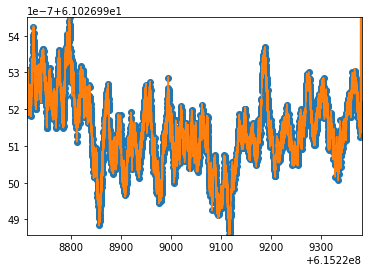

In [20]:
#do a spline interpolation, but it wont take more than 6680 points
n = 6680
lat_spline = interpolate.splrep(pos_sec_since[0:n],pos_data.latitude_decimal_degree[0:n])
x2 = np.linspace(min(pos_sec_since[0:n]),max(pos_sec_since[0:n]),n*1000)
y2 = interpolate.splev(x2,lat_spline)
plt.plot(pos_sec_since[0:n], pos_data.latitude_decimal_degree[0:n], 'o', x2, y2)
plt.ylim(min(pos_data.latitude_decimal_degree[0:n]),max(pos_data.latitude_decimal_degree[0:n]))
plt.xlim(min(pos_sec_since[0:n]),max(pos_sec_since[0:n]))

(615228922.590745, 615240214.872921)

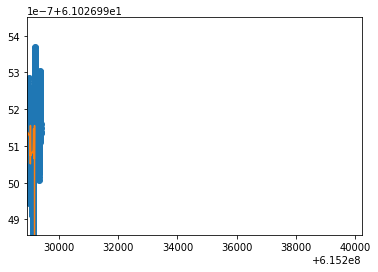

In [7]:
#do spline interpolation and use event markers instead of linspace
n = 6680
lat_spline = interpolate.splrep(pos_sec_since[0:n],pos_data.latitude_decimal_degree[0:n])
# x2 = np.linspace(min(pos_sec_since[0:n]),max(pos_sec_since[0:n]),n*1000)
y2 = interpolate.splev(event_sec_since,lat_spline)
plt.plot(pos_sec_since[0:n], pos_data.latitude_decimal_degree[0:n], 'o', event_sec_since, y2)
plt.ylim(min(pos_data.latitude_decimal_degree[0:n]),max(pos_data.latitude_decimal_degree[0:n]))
plt.xlim(min(event_sec_since[0:n]),max(event_sec_since[0:n]))